In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import hvplot.pandas
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Read In and Clean Data

In [2]:
# Read in data from csv file
wine_data = Path("Resources/winemag-data-130k-v2.csv")
# Convert to dataframe
wine_df = pd.read_csv(wine_data)
wine_df.head(5)

id   country                                        description  \
0   0     Italy  Aromas include tropical fruit, broom, brimston...   
1   1  Portugal  This is ripe and fruity, a wine that is smooth...   
2   2        US  Tart and snappy, the flavors of lime flesh and...   
3   3        US  Pineapple rind, lemon pith and orange blossom ...   
4   4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0                 Etna                NaN       Kerin O’Keefe   
1                  NaN                NaN          Roger Voss   
2    Willamette Valley  Willamette Valley        Paul Gregutt   
3  Lake Michigan Shore                NaN  Alexander Peartree   
4    Willamette Valley  Willamette Valley        Paul Gregutt   

  taster_twitter_handle                                              title  \
0          @kerinokeefe                  Nicosia 2013 Vulkà Bianco  (Etna)   
1            @vossroger      Quinta dos Avidagos 2011 Avidagos Red (Douro)   
2           @paulgwine       Rainstorm 2013 Pinot Gris (Willamette Valley)   
3                   NaN  St. Julian 2013 Reserve Late Harvest Riesling ...   
4           @paulgwine   Sweet Cheeks 2012 Vintner's Reserve Wild Child...   

          variety               winery  
0     White Blend              Nicosia  
1  Portuguese Red  Quinta dos Avidagos  
2      Pinot Gris            Rainstorm  
3        Riesling           St. Julian  
4      Pinot Noir         Sweet Cheeks

In [3]:
# Clean and transform data
# Drop unnecessary columns
df = wine_df.loc[:,["country", "description", "points",
                                    "province", "variety"]]
# Drop null values
df = df.dropna(how='any')
df.head(5)

country                                        description  points  \
0     Italy  Aromas include tropical fruit, broom, brimston...      87   
1  Portugal  This is ripe and fruity, a wine that is smooth...      87   
2        US  Tart and snappy, the flavors of lime flesh and...      87   
3        US  Pineapple rind, lemon pith and orange blossom ...      87   
4        US  Much like the regular bottling from 2012, this...      87   

            province         variety  
0  Sicily & Sardinia     White Blend  
1              Douro  Portuguese Red  
2             Oregon      Pinot Gris  
3           Michigan        Riesling  
4             Oregon      Pinot Noir

In [4]:
# List number of descriptions for each country
df["country"].value_counts()

US                        54504
France                    22093
Italy                     19540
Spain                      6645
Portugal                   5691
Chile                      4471
Argentina                  3800
Austria                    3345
Australia                  2329
Germany                    2165
New Zealand                1419
South Africa               1401
Israel                      505
Greece                      466
Canada                      257
Hungary                     146
Bulgaria                    141
Romania                     120
Uruguay                     109
Turkey                       90
Slovenia                     87
Georgia                      86
England                      74
Croatia                      73
Mexico                       70
Moldova                      59
Brazil                       52
Lebanon                      35
Morocco                      28
Peru                         16
Ukraine                      14
Serbia  

In [6]:
# Store the value counts as a variable
values = df["country"].value_counts() 

In [7]:
# Create list of country names to keep
countries_to_keep = ["US", "France", "Italy", "Spain", "Portugal", "Chile", "Argentina", "Austria",
                  "Australia", "Germany", "New Zealand", "South Africa"]

In [8]:
# Drop countries with less than 1000 descriptions
# Choose cutoff value to create list of countries
countries_to_replace = values.index[values<1000]

# Replace in dataframe
for ctry in countries_to_replace:
    df["country"] = df["country"].replace(ctry, "Other")

# Check to make sure binning was successful
df["country"].value_counts()

reduced_df=df.loc[df["country"].isin(countries_to_keep), :]
reduced_df.head()


country                                        description  points  \
0     Italy  Aromas include tropical fruit, broom, brimston...      87   
1  Portugal  This is ripe and fruity, a wine that is smooth...      87   
2        US  Tart and snappy, the flavors of lime flesh and...      87   
3        US  Pineapple rind, lemon pith and orange blossom ...      87   
4        US  Much like the regular bottling from 2012, this...      87   

            province         variety  
0  Sicily & Sardinia     White Blend  
1              Douro  Portuguese Red  
2             Oregon      Pinot Gris  
3           Michigan        Riesling  
4             Oregon      Pinot Noir

# Preprocess Data to Build Word2Vec Model

In [9]:
# Transform words into vectors using NLP
# Drop stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
reduced_df['description'] = reduced_df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
reduced_df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katyp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\katyp\AppData\Local\Temp\ipykernel_20792\608277938.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['description'] = reduced_df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


country                                        description  points  \
0     Italy  Aromas include tropical fruit, broom, brimston...      87   
1  Portugal  This ripe fruity, wine smooth still structured...      87   
2        US  Tart snappy, flavors lime flesh rind dominate....      87   
3        US  Pineapple rind, lemon pith orange blossom star...      87   
4        US  Much like regular bottling 2012, comes across ...      87   

            province         variety  
0  Sicily & Sardinia     White Blend  
1              Douro  Portuguese Red  
2             Oregon      Pinot Gris  
3           Michigan        Riesling  
4             Oregon      Pinot Noir

In [10]:
# Lemmatization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)
reduced_df['description'] = reduced_df['description'].apply(lemmatize_words)
reduced_df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katyp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\katyp\AppData\Local\Temp\ipykernel_20792\2083711034.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['description'] = reduced_df['description'].apply(lemmatize_words)


country                                        description  points  \
0     Italy  Aromas include tropical fruit, broom, brimston...      87   
1  Portugal  This ripe fruity, wine smooth still structured...      87   
2        US  Tart snappy, flavor lime flesh rind dominate. ...      87   
3        US  Pineapple rind, lemon pith orange blossom star...      87   
4        US  Much like regular bottle 2012, come across rat...      87   

            province         variety  
0  Sicily & Sardinia     White Blend  
1              Douro  Portuguese Red  
2             Oregon      Pinot Gris  
3           Michigan        Riesling  
4             Oregon      Pinot Noir

In [11]:
# Tokenize descriptions to split sentences into word components
descriptions = reduced_df.description.apply(gensim.utils.simple_preprocess)
descriptions

0         [aromas, include, tropical, fruit, broom, brim...
1         [this, ripe, fruity, wine, smooth, still, stru...
2         [tart, snappy, flavor, lime, flesh, rind, domi...
3         [pineapple, rind, lemon, pith, orange, blossom...
4         [much, like, regular, bottle, come, across, ra...
                                ...                        
129966    [notes, honeysuckle, cantaloupe, sweeten, deli...
129967    [citation, give, much, decade, bottle, age, pr...
129968    [well, drained, gravel, soil, give, wine, cris...
129969    [dry, style, pinot, gris, crisp, acidity, it, ...
129970    [big, rich, off, dry, power, intense, spicines...
Name: description, Length: 127403, dtype: object

In [12]:
# Word2Vec model
# Create the model
model = gensim.models.Word2Vec(window=1, min_count=1, workers=8)
# Build its vocabulary
model.build_vocab(descriptions, progress_per=100)
# Train the model
model.train(descriptions, total_examples=model.corpus_count, epochs= model.epochs)
# Save the model to use later
model.save("Resources/descriptions.model")

In [13]:
# Test the model looking for similar words
model.wv.most_similar("bright")

[('vibrant', 0.8028075098991394),
 ('lively', 0.7343376874923706),
 ('fragrant', 0.7268516421318054),
 ('fresh', 0.7125094532966614),
 ('buoyant', 0.6999592185020447),
 ('zesty', 0.6933197975158691),
 ('pristine', 0.6905989646911621),
 ('vivid', 0.6863913536071777),
 ('vivacious', 0.6860535144805908),
 ('zippy', 0.6824751496315002)]

In [14]:
# Test the model with similarity of different words
model.wv.similarity(w1="sweet",w2="fruity")

0.38572335

# Calculate Vector Representations of Descriptions

In [15]:
# Get vector representations of descriptions
# Define our function that creates description vectors:
def get_desc_vec(document):
    return np.array(sum(model.wv[word] for word in document)/len(document))

desc_vecs = descriptions.apply(get_desc_vec).tolist()


In [16]:
# Create a dataframe for the description vectors
desc_vec_df = pd.DataFrame(desc_vecs)

In [17]:
# Display dataframe
desc_vec_df.head()

0         1         2         3         4         5         6   \
0 -0.544373  0.251527 -0.231462  0.359331  0.213817 -0.432329  0.596215   
1 -0.526124  0.117852  0.157128  0.302073 -0.093871 -0.656173  0.469117   
2 -0.321243  0.076458 -0.037892  0.386394  0.293439 -0.793782  0.552956   
3 -0.185500  0.225905 -0.113349  0.243122  0.209984 -0.545853  0.520241   
4 -0.300691  0.413745  0.030895  0.126983  0.030374 -0.237182  0.228529   

         7         8         9   ...        90        91        92        93  \
0  0.650667 -0.012864 -0.350316  ...  0.766054  0.334074  0.489529 -0.287695   
1  1.150432  0.072485 -0.655270  ...  0.807636  0.106540  0.106949 -0.278631   
2  0.851747 -0.110115 -0.427036  ...  0.541493  0.339485  0.598294 -0.273241   
3  0.577557 -0.185195 -0.423659  ...  0.517662  0.345284  0.622374 -0.111633   
4  0.594573 -0.217300 -0.189508  ...  0.411947  0.155782  0.072992  0.035997   

         94        95        96        97        98        99  
0  0.443301  0.280593  0.311333 -0.054287 -0.104214  0.614481  
1  0.954108  0.105415  0.303894 -0.265384  0.214212  0.199348  
2  0.372769  0.158324  0.103537 -0.198695 -0.062458  0.453083  
3  0.341534  0.214846  0.183456 -0.400007 -0.216027  0.611714  
4  0.449952  0.140180  0.100206 -0.255889  0.270941  0.007586  

[5 rows x 100 columns]

In [18]:
desc_vec_df.values

array([[-0.54437315,  0.25152725, -0.23146187, ..., -0.05428651,
        -0.10421418,  0.6144812 ],
       [-0.52612394,  0.11785208,  0.15712775, ..., -0.26538384,
         0.21421161,  0.19934797],
       [-0.32124278,  0.07645773, -0.03789225, ..., -0.19869518,
        -0.06245801,  0.4530832 ],
       ...,
       [-0.49409053,  0.10629141, -0.05732858, ..., -0.19125988,
         0.16019873,  0.08657727],
       [-0.49668372,  0.16484226, -0.14368121, ..., -0.01185584,
         0.03110846,  0.27782878],
       [-0.35247254,  0.11308211, -0.00096475, ..., -0.09005864,
         0.16117367,  0.27829933]], dtype=float32)

# Build TSNE Model

In [19]:
# Save the labels into a variable l.
l = reduced_df['country']
 
# Drop the label feature and 
# Store the pixel data in d.
d = reduced_df.drop("description", axis=1)

In [20]:
# Data-preprocessing: Standardizing the data
standardized_data = StandardScaler().fit_transform(desc_vecs)
print(standardized_data.shape)

(127403, 100)


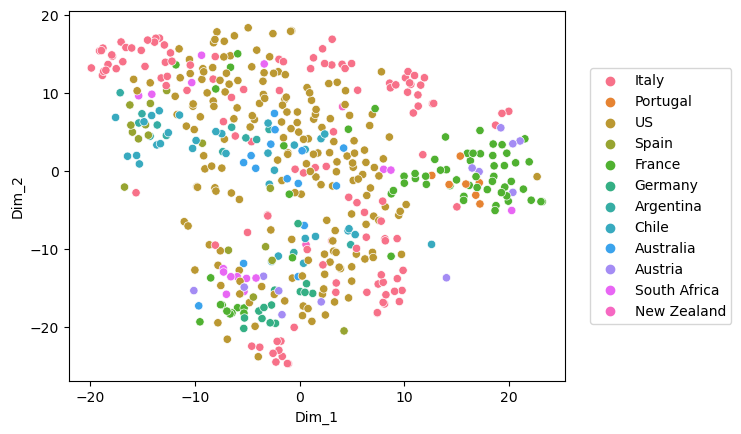

In [21]:
# Picking the top 1000 points as TSNE
# takes a lot of time for 15K points
data_500 = standardized_data[0:500, :]
labels_500 = l[0:500]
 
model = TSNE(n_components = 2, random_state = 0)
# configuring the parameters
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations
# for the optimization = 1000
 
tsne_data = model.fit_transform(data_500)
 
# creating a new data frame which
# help us in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels_500)).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))
 
# Plotting the result of tsne
g = sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
               hue='label')
custom_palette = sns.color_palette("dark")
g.legend(loc='right', bbox_to_anchor=(1.35, 0.5), ncol=1)
plt.show()

# Build KMeans Clusters

In [22]:
# Elbow Method to find the optimal number of clusters
num_clusters_range = range(1, 11)

wcss = []
for k in num_clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init = "auto")
    kmeans.fit(desc_vec_df)
    wcss.append(kmeans.inertia_)

# Create a DataFrame for the elbow curve
df_elbow = pd.DataFrame({"k_value": num_clusters_range, "inertia_value": wcss})

# Plot the elbow curve using hvplot
elbow_curve = df_elbow.hvplot.line(x="k_value", y="inertia_value", title="Elbow Curve")
elbow_curve

:Curve   [k_value]   (inertia_value)

In [23]:
# Apply k-means clustering with the optimal number of clusters
optimal_k = 4 # Add the optimal k value based on the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init = "auto")
cluster_assignments_kmeans = kmeans.fit_predict(desc_vec_df)

# Add the cluster assignments to new dataframe
desc_vec_kmeans_predictions_df = desc_vec_df.copy()
desc_vec_kmeans_predictions_df['kmeans_cluster'] = cluster_assignments_kmeans

# Plot the clusters
desc_vec_kmeans_predictions_df.hvplot.scatter(
    x="27",
    y="83",
    by="kmeans_cluster"
)

:NdOverlay   [kmeans_cluster]
   :Scatter   [27]   (83)

In [24]:
# Add KMeans cluster values to reduced dataframe
cluster_wine_df=reduced_df.copy()
cluster_wine_df["kmeans_cluster"]=cluster_assignments_kmeans

# Display the clusters
for cluster_id in range(optimal_k):
    print(f"Cluster {cluster_id}:")
    print(cluster_wine_df[cluster_wine_df['kmeans_cluster'] == cluster_id]['variety'].value_counts().head())
    print("\n")

Cluster 0:
Pinot Noir                  6281
Cabernet Sauvignon          4160
Chardonnay                  3028
Red Blend                   2511
Bordeaux-style Red Blend    1917
Name: variety, dtype: int64


Cluster 1:
Chardonnay         6131
Riesling           4033
Sauvignon Blanc    3035
White Blend        1427
Sparkling Blend    1393
Name: variety, dtype: int64


Cluster 2:
Bordeaux-style Red Blend    3767
Chardonnay                  2289
Pinot Noir                  2158
Portuguese Red              1982
Rosé                        1376
Name: variety, dtype: int64


Cluster 3:
Red Blend             5660
Cabernet Sauvignon    4579
Pinot Noir            4260
Nebbiolo              2244
Syrah                 2145
Name: variety, dtype: int64




# Utilize PCA Followed by KMeans Clustering

In [25]:
# Instantiate the PCA instance and declare the number of PCA variables
pca = PCA(n_components=2)

In [26]:
# Fit the PCA model on the vectors DataFrame
desc_vec_pca = pca.fit_transform(desc_vec_df)

# Review the first 5 rows of list data
desc_vec_pca[:5]

array([[-0.8078625 ,  0.4863188 ],
       [ 0.42512643, -0.10487352],
       [-0.25375658,  1.079886  ],
       [-0.6822475 ,  1.0299325 ],
       [ 0.91249895, -0.36867708]], dtype=float32)

In [27]:
# Calculate the PCA explained variance ratio
pca.explained_variance_ratio_
print(pca.explained_variance_ratio_)
print("Total explained variance = .29")

[0.16006628 0.12833805]
Total explained variance = .29


In [28]:
# Create the PCA DataFrame
desc_vec_pca_df = pd.DataFrame(
    desc_vec_pca,
    columns=["PCA1", "PCA2"]
)

# Review the PCA DataFrame
desc_vec_pca_df.head()

PCA1      PCA2
0 -0.807863  0.486319
1  0.425126 -0.104874
2 -0.253757  1.079886
3 -0.682248  1.029932
4  0.912499 -0.368677

In [29]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=0, n_init = "auto")
    k_model.fit(desc_vec_pca_df)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

k       inertia
0  1  73962.734375
1  2  49326.156250
2  3  26506.335938
3  4  20804.308594
4  5  15955.458984

In [30]:
# Plot the Elbow Curve
df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)


:Curve   [k]   (inertia)

In [31]:
# Determine optimal number of clusters based on elbow frame above
print("Optimal number of clusters = 5")

Optimal number of clusters = 5


In [32]:
# Define the model with 5 clusters
cluster_number = 5
model = KMeans(n_clusters=cluster_number, random_state=0, n_init = "auto")

# Fit the model
model.fit(desc_vec_pca_df)

# Make predictions
k_5 = model.predict(desc_vec_pca_df)

# Create a copy of the PCA DataFrame
pca_to_cluster_df=desc_vec_pca_df.copy()

# Add a class column with the labels
pca_to_cluster_df["pca_clusters"] = k_5
pca_to_cluster_df.head()

PCA1      PCA2  pca_clusters
0 -0.807863  0.486319             4
1  0.425126 -0.104874             2
2 -0.253757  1.079886             4
3 -0.682248  1.029932             4
4  0.912499 -0.368677             2

In [33]:
# Plot the clusters
pca_to_cluster_df.hvplot.scatter(
    x="PCA1",
    y="PCA2",
    by="pca_clusters"
)

:NdOverlay   [pca_clusters]
   :Scatter   [PCA1]   (PCA2)

C:\Users\katyp\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


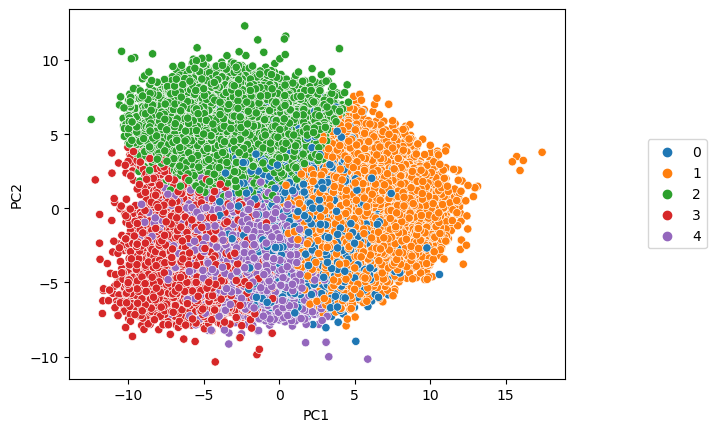

In [34]:
# Display PCA clusters with seaborn
Sc = StandardScaler()
X = Sc.fit_transform(desc_vec_df)
pca = PCA(2)
pca_data = pd.DataFrame(pca.fit_transform(X),columns=["PC1","PC2"])
kmeans =KMeans(n_clusters=5).fit(X)
pca_data["cluster"] = pd.Categorical(kmeans.labels_)
g = sns.scatterplot(data=pca_data, x="PC1", y="PC2",
               hue="cluster")
g.legend(loc="right", bbox_to_anchor=(1.3, 0.5), ncol=1)

In [35]:
# Add a class column with the labels for PCA clusters
cluster_wine_df["pca_clusters"] = k_5

for cluster_id in range(cluster_number):
    print(f"Cluster {cluster_id}:")
    print(cluster_wine_df[cluster_wine_df['pca_clusters'] == cluster_id]['variety'].value_counts().head())
    print("\n")

Cluster 0:
Pinot Noir                  5744
Cabernet Sauvignon          4264
Bordeaux-style Red Blend    3377
Red Blend                   3360
Syrah                       2057
Name: variety, dtype: int64


Cluster 1:
Chardonnay         5716
Sauvignon Blanc    2526
Riesling           2180
Rosé               1651
White Blend        1105
Name: variety, dtype: int64


Cluster 2:
Pinot Noir                  4065
Bordeaux-style Red Blend    2703
Cabernet Sauvignon          2436
Chardonnay                  1655
Red Blend                   1305
Name: variety, dtype: int64


Cluster 3:
Red Blend             3777
Cabernet Sauvignon    2481
Pinot Noir            1974
Nebbiolo              1927
Sangiovese            1678
Name: variety, dtype: int64


Cluster 4:
Chardonnay         3745
Riesling           2656
Sauvignon Blanc    1776
Sparkling Blend     900
White Blend         811
Name: variety, dtype: int64




# Use KNearestNeighbors to Predict Clusters

In [45]:
# Use K Nearest Neighbors to assign user input to a cluster

# Create dataframe with pca cluster column added to description vectors
desc_vec_with_pca_df = desc_vec_df.copy()
desc_vec_with_pca_df["pca_clusters"] = k_5

# Separate the target variable from the features
y = desc_vec_with_pca_df["pca_clusters"]
X = desc_vec_with_pca_df.drop(columns = "pca_clusters")

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=0, 
                                                    stratify=y)

#Instantiate the KNN model
neigh = KNeighborsClassifier(n_neighbors=3)

# Fit the model
neigh.fit(X_train, y_train)

# Save the model
# Possible code for the save:
#model = knn() # put yours model
#model.fit(X_train, Y_train)

# save the model to disk
#filename = 'finalized_model.sav'
#pickle.dump(model, open(filename, 'wb'))


# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)

KNeighborsClassifier(n_neighbors=3)

In [46]:
# Score the model using test data
print(f"Training Data Score: {neigh.score(X_train, y_train)}")
print(f"Testing Data Score: {neigh.score(X_test, y_test)}")

Training Data Score: 0.9387558606831882
Testing Data Score: 0.872531474678974


In [39]:
# Make predictions using the test data
predictions = neigh.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(10)

Prediction  Actual
0            2       2
1            1       1
2            3       3
3            1       1
4            3       3
5            0       0
6            0       0
7            4       4
8            1       1
9            3       3
10           0       0
11           0       0
12           3       0
13           0       0
14           4       4
15           0       0
16           1       0
17           1       1
18           0       0
19           0       0

In [ ]:
#Define function to convert user input text into vector representation
def data_processing(data, result):
    # load word2vec model:
    wvmodel = KeyedVectors.load("Resources/descriptions.model", mmap='r')
    
    def drop_stop_words(text):
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])

    def lemmatize_words(text):
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)

    def get_desc_vec(document, wvmodel):
    return np.array(sum(wvmodel.wv[word] for word in document)/len(document))

    # calculate vector representations of descriptions - same as jupyter notebook:
    text = drop_stop_words(data)
    text = lemmatize_words(data)
    text = gensim.utils.simple_preprocess(data)
    vectors = get_desc_vec(text, wvmodel)
    
    # sum the vectors
    vector_sum = sum(wvmodel.wv[word] for word in data)

    # take their mean
    vector_mean = vector_sum//len(data)
    
    # load the knn model
    
    # predict using the vector that we created

    # model.predict(the mean of the vectors we did with the used description)

	return result


#print(neigh.predict([the vector made from the means of the vectors from the user input]))

# Display Final DataFrames with Comparison of Clusters

In [ ]:
# Display reduced dataframe with clusters added
cluster_wine_df.head()

In [ ]:
# Create dataframe with kmeans cluster column added to description vectors
desc_vec_with_kmeans_df = desc_vec_df.copy()
desc_vec_with_kmeans_df["kmeans_clusters"] = cluster_assignments_kmeans
desc_vec_with_kmeans_df.head()

In [ ]:
# Create dataframe with pca cluster column added to description vectors
desc_vec_with_pca_df = desc_vec_df.copy()
desc_vec_with_pca_df["pca_clusters"] = k_5
desc_vec_with_pca_df.head()

In [ ]:
# Create dictionary to hold cluster number and wine list
wine_type_dict = [{"cluster": 0, "variety": "Pinot Noir, Cabernet Sauvignon, Red Blend, Bordeaux-style Red Blend, Syrah"},
                    {"cluster": 1, "variety": "Red Blend, Cabernet Sauvignon, Nebbiolo, Pinot Noir, Sangiovese"},
                    {"cluster":2, "variety": "Chardonnay, Riesling, Sauvignon Blanc, Sparkling Blend, Rose"},
                    {"cluster": 3, "variety": "Pinot Noir, Bordeaux-style Red Blend, Cabernet Sauvignon, Chardonnay, Red Blend"},
                    {"cluster": 4, "variety": "Chardonnay, Sauvignon Blanc, Riesling, Rose, Pinot Noir"}]
wine_type_df = pd.DataFrame(wine_type_dict)
wine_type_df.head()

In [ ]:
# Write final dataframes to csv files
cluster_wine_df.to_csv("Resources/cluster_wine.csv", header=True)
desc_vec_with_kmeans_df.to_csv("Resources/desc_kmeans.csv", header=True)
desc_vec_with_pca_df.to_csv("Resources/desc_pca.csv", header=True)
wine_type_df.to_csv("Resources/wine_type.csv", header=True)

In [ ]:
#import string

#a red wine that does not smell like horse
#a red horse that does not smell like wine

#a tart not sweet wine
#a sweet wine not tart



#'your custom word here' in model.wv
#user_input = 'Red wine with, juicy..... fruity dessert flavors laser-like dkljgbioerubgowrbgowergbwoergb'

# Text box that takes user input js
# [  'Red wine with juicy fruity dessert flavors' ]  => pass to flask in a post

#'Red wine with juicy fruity dessert flavors'
#user_input_nopunc = user_input.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
#print(user_input)
#print(user_input_nopunc)
# in flask
#description = [word.lower().strip() for word in user_input_nopunc.split()]
#clean_description = [w for w in description if w in model.wv]
#sum(model.wv[word] for word in clean_description)
# take words in the description, get the vectors (if they exist), combine them and find similar with cosine similarity



# import your model
# import your description vectors

# Then  create routes and stuff


